In [1]:
import anndata
import numpy as np
#import scanpy as sc

from Bio import Seq
from Bio import SeqIO
import pandas
import matplotlib.pyplot as pl
import rapidfuzz as fuzz
from rapidfuzz.distance import Hamming
from rapidfuzz.distance import Levenshtein
import glob
import argparse
import gzip

# This is now the proper code for CountASAP as of 06/09/25
- I had been dealing with old code and it unsurprisingly didn't work out...

In [1]:
# This is the path for trying out the ASAPseq data
#asapPath = '/home/bizon/Desktop/projects/darpa_project/data/asap_yfv_3001/asapSeq_barcodes.csv'
#pandas.read_csv(asapPath)

# All of this was stolen directly from the asap_process script
If anything is changed in here, make sure I make a note of it and change it in the OG!!!

In [ ]:
countASAP -cr MYPATH/citeR1.fastq -br MYPATH/citeR2.fastq -wl MYPATH/d101_barcodes.csv -ref MYPATH/citeSeq_codes.csv -awl False --assay CITE

In [2]:

r2N= 'CITEseq/CSYGXD101_S41_L004_R1_001.fastq'
r3N = 'CITEseq/CSYGXD101_S41_L004_R2_001.fastq'
whitelist = 'CITEseq/d101_barcodes.csv'
# reference = codePath and is asapSeq_barcodes.csv
codePath = 'CITEseq/citeSeq_codes.csv' # NOTE: BAD EXPLANATION OF VARIABLE IN HELP
outName = 'test_l4_out.csv'
cell_mismatch_tol = 1
barcode_percent_match = 0.95
procs = -1
from_atac = 'False'
assay = 'CITE'
# Need to see what that one is
drop_exact_UMI = 'True'

# Data num is important if we need to auto-load in files.
# Again, leave this here in case I want to automate this
# script a bit more generally, but 
#data_num = asapDir[-4:-1]

# Change the code to now allow for loading in GZIP files
if r2N.find('.gz') != -1:
    with gzip.open(r2N, "rt") as handle:
        r2 = list(SeqIO.parse(handle, "fastq"))
else:
    r2 = list(SeqIO.parse(r2N, "fastq"))

if r3N.find('.gz') != -1:
    with gzip.open(r3N, "rt") as handle:
        r3 = list(SeqIO.parse(handle, "fastq"))
else:
    r3 = list(SeqIO.parse(r3N, "fastq"))
    

# This will work for r1, r2, or r3
# Get the read id for every single sample
# Can add this as an option for users if we want, but this was really just an artifact
# of making sure that our data was properly deposited... For now don't support
check_id = False
if check_id:
    uniq_id = [a.name[-14:] for a in r2]
    id_df = pandas.DataFrame(uniq_id)

    uniq_i2 = [a.name[-14:] for a in r3]
    id_df2 = pandas.DataFrame(uniq_i2)

    print(id_df.equals(id_df2))

In [3]:

seq2 = [str(a.seq) for a in r2]
# Need to be better about clearing memory as we go
r2 = []

asap_barcodes = pandas.read_csv(codePath)
#colnames = [[a][0][3:] for a in asap_barcodes['name'].values]
# I HATE doing things this way but the python parser makes it a pain to pass T/F statements
if from_atac.lower()=='true':
    atac = anndata.read_h5ad(whitelist)
    barcodes = atac.obs_names
else:
    barcodes_temp = pandas.read_csv(whitelist,header=0)
    barcodes = [a[0] for a in barcodes_temp.values]

index_list = []

In [4]:
# Initialization things, dont need to change any of these...
##########################################################################
# Could parallelize this as well if it is slow...
# pretty fast though. Even with 10k cells its less than a second
# List of CellIDs
comp_list = []
for xx in barcodes:
    if assay.lower() == 'asap':
        comp_list = comp_list + [str(Seq.Seq(xx[:-2]).reverse_complement())]
    elif assay.lower() == 'cite':
        # Note, you dont need the reverse complement for citeSeq
        comp_list = comp_list + [xx[:-2]]

#  Convert barcodes to a string
checkList = asap_barcodes['sequence'].values

# How we gonna chunk up our sequences?
# If you are well over 100k sequences, you gotta chunk up 
if len(seq2) > 1*10**5:
    num_fact = np.ceil(len(seq2)/10**5)
    chunkers = int(np.ceil(len(seq2)/num_fact))
    chunk_list = []
    for chunker in np.arange(int(num_fact)):
        chunk_list = chunk_list + [[chunkers*chunker,chunkers*(chunker+1)]]

cell_mismatch = len(comp_list[0])-cell_mismatch_tol
fin_cellMatch = []; test_mismatch = False
#dup_match = []
pre_len = 0

# So this block of code was MUCH slower with Levenshtein distance
- Took 12 minutes to process 3 out of 40 blocks, while Hamming does all 40 in 6 minutes
- I think it's because the "score cutoff" needs to be changed when using a different metric
- Obviously the different scorers will give... different scores. 
- Reviewer was right, I think it turns out. Levenshtein IS much more permissive

In [7]:
    x=fuzz.process.cdist(sub_seq2,comp_list,scorer=Hamming.similarity,score_cutoff=cell_mismatch,workers=procs)
    # Looks like this "nonzero" function might be a fast way to sort
    # reads to their respective cell identifiers
    matched_cell_coords = x.nonzero()

In [8]:
x2=fuzz.process.cdist(sub_seq2,comp_list,scorer=Levenshtein.similarity,score_cutoff=cell_mismatch,workers=procs)
# Looks like this "nonzero" function might be a fast way to sort
# reads to their respective cell identifiers
matched_cell_coords2 = x2.nonzero()

In [16]:
len(matched_cell_coords[1])

33410

In [17]:
len(matched_cell_coords2[1])

14632964

In [35]:
import time

In [36]:
time.time()

1749848877.86307

In [6]:
for chunk in np.arange(int(num_fact)):
    sub_seq2 = seq2[chunk_list[chunk][0]:chunk_list[chunk][1]]
    x=fuzz.process.cdist(sub_seq2,comp_list,scorer=Hamming.similarity,score_cutoff=cell_mismatch,workers=procs)
    # Looks like this "nonzero" function might be a fast way to sort
    # reads to their respective cell identifiers
    matched_cell_coords = x.nonzero()
    # Drop x for memory
    x = []
    print('finished cell chunk ' + str(chunk) + "/" + str(num_fact))
    temptemp = np.transpose(pandas.DataFrame(matched_cell_coords))
    # Control for memory...
    matched_cell_coords = []
    # What this "drop_duplicates" is doing is dropping those reads that have ambiguous assignments
    # i.e. one read is being assigned to two barcodes (or more than two)
    cell_matched_reads = temptemp.drop_duplicates(0)#.values # Used to turn it into values, now turn it into DF.
    #if save_dups:
    #    dup_match = dup_match + temptemp[temptemp.duplicated(0,keep="first")].values
    # Our read index is resetting every time, so we have to add the chunk list in...
    temptemp = []
    umi_dropped = []
    #print('starting umiDrop')
    holder = 0
    if drop_exact_UMI.lower() == 'true':
        # This is obviously much faster than iterating through all 
        umi_drop= pandas.DataFrame(np.array(sub_seq2)[cell_matched_reads[0].values]).drop_duplicates()
        new_matched_reads=cell_matched_reads.iloc[umi_drop.index].values
        cell_matched_reads = []
        umi_drop = []
    else:
        # So this is WILDLY slow. Need to do something about that...
        # I could probably remove the FOR loop and just change the scoring of the CDIST
        # function??? Yea that's probably the best option...
        for refSeq in cell_matched_reads[1].drop_duplicates().values:
            umiCheck = cell_matched_reads[cell_matched_reads[1]==refSeq]
            if len(umiCheck) < 2:
                #print('they do exist!')
                continue
            # Need to reset the indices of the sequences so we know which to drop from the UMIs...
            seqCheck = np.array(sub_seq2)[umiCheck[0].values]
            UMIs = [a[16:] for a in seqCheck]

            x=fuzz.process.cdist(UMIs,UMIs,scorer=Hamming.similarity,score_cutoff=len(UMIs[0])-1,workers=procs)
            np.fill_diagonal(x,0)
            # Alright there probably won't be that many of these, lets do some slow coding.
            pair_dups = np.vstack((x.nonzero()))
            if np.shape(pair_dups)[1] == 0:
                findup = pair_dups[0]
            else:
                redup = []
                for j in np.arange(np.shape(pair_dups)[1]):
                    n1 = pair_dups[0,j]
                    n2 = pair_dups[1,j]
                    if n1 > n2:
                        redup = redup + [[n1,n2]]
                    else:
                        redup = redup + [[n2,n1]]

                # Two drop duplicates here. First delete duplicate PAIRS, then delete duplicate ENTRIES
                findup = pandas.DataFrame(redup).drop_duplicates().iloc[:,0].drop_duplicates().values
            
            temperDF = umiCheck.reset_index(drop=True)
            temperDF = temperDF.drop(findup,axis=0)
            umi_dropped = umi_dropped + [temperDF.values]
            holder+=1
            if holder % 100 == 0:
                print(holder/len(cell_matched_reads[1].drop_duplicates()))
        new_matched_reads = np.concatenate(umi_dropped)
    ###########################################################

    new_matched_reads[:,0] = new_matched_reads[:,0] + pre_len

    pre_len = pre_len + len(sub_seq2)

    fin_cellMatch = fin_cellMatch + [new_matched_reads]
    new_matched_reads = []

    if test_mismatch:
        # so with 1bp mismatch we have ~140 duplicates in over a million reads... Pretty good
        nonZero_len = len(matched_cell_coords)
        singlet_len = len(cell_matched_reads)
        frac_doubCount_cellID = (nonZero_len-singlet_len)/len(sub_seq2)

finished cell chunk 0/40.0
finished cell chunk 1/40.0
finished cell chunk 2/40.0
finished cell chunk 3/40.0
finished cell chunk 4/40.0
finished cell chunk 5/40.0
finished cell chunk 6/40.0
finished cell chunk 7/40.0
finished cell chunk 8/40.0
finished cell chunk 9/40.0
finished cell chunk 10/40.0
finished cell chunk 11/40.0
finished cell chunk 12/40.0
finished cell chunk 13/40.0
finished cell chunk 14/40.0
finished cell chunk 15/40.0
finished cell chunk 16/40.0
finished cell chunk 17/40.0
finished cell chunk 18/40.0
finished cell chunk 19/40.0
finished cell chunk 20/40.0
finished cell chunk 21/40.0
finished cell chunk 22/40.0
finished cell chunk 23/40.0
finished cell chunk 24/40.0
finished cell chunk 25/40.0
finished cell chunk 26/40.0
finished cell chunk 27/40.0
finished cell chunk 28/40.0
finished cell chunk 29/40.0
finished cell chunk 30/40.0
finished cell chunk 31/40.0
finished cell chunk 32/40.0
finished cell chunk 33/40.0
finished cell chunk 34/40.0
finished cell chunk 35/40.0
fi

In [52]:
seq2 = []
barcode_mismatch = 100*barcode_percent_match
fin_barcodeMatch = []
pre_len = 0
r3 = list(SeqIO.parse(r3N, "fastq"))
seq3 = [str(a.seq) for a in r3]
r3 = []
for chunk in np.arange(int(num_fact)):
    sub_seq3 = seq3[chunk_list[chunk][0]:chunk_list[chunk][1]]
    zzz=fuzz.process.cdist(checkList,sub_seq3,scorer=fuzz.fuzz.partial_ratio,score_cutoff=barcode_mismatch,workers=procs)
    matched_code_coords = zzz.nonzero()
    barcode_matched_reads = np.transpose(pandas.DataFrame(matched_code_coords)).drop_duplicates(1).values

    barcode_matched_reads[:,1] = barcode_matched_reads[:,1] + pre_len

    pre_len = pre_len + len(sub_seq3)

    fin_barcodeMatch = fin_barcodeMatch + [barcode_matched_reads]
    print('finished barcode chunk ' + str(chunk) + "/" + str(num_fact))

    if test_mismatch:
        # so with 1bp mismatch we have ~140 duplicates in over a million reads... Pretty good
        nonZero_len = len(matched_code_coords)
        singlet_len = len(barcode_matched_reads)
        frac_doubCount_barcode = (nonZero_len-singlet_len)/len(sub_seq3)
        dup_match_cell = dup_match_cell + [frac_doubCount_barcode]

# Final data processing...

finished barcode chunk 0/40.0
finished barcode chunk 1/40.0
finished barcode chunk 2/40.0
finished barcode chunk 3/40.0
finished barcode chunk 4/40.0
finished barcode chunk 5/40.0
finished barcode chunk 6/40.0
finished barcode chunk 7/40.0
finished barcode chunk 8/40.0
finished barcode chunk 9/40.0
finished barcode chunk 10/40.0
finished barcode chunk 11/40.0
finished barcode chunk 12/40.0
finished barcode chunk 13/40.0
finished barcode chunk 14/40.0
finished barcode chunk 15/40.0
finished barcode chunk 16/40.0
finished barcode chunk 17/40.0
finished barcode chunk 18/40.0
finished barcode chunk 19/40.0
finished barcode chunk 20/40.0
finished barcode chunk 21/40.0
finished barcode chunk 22/40.0
finished barcode chunk 23/40.0
finished barcode chunk 24/40.0
finished barcode chunk 25/40.0
finished barcode chunk 26/40.0
finished barcode chunk 27/40.0
finished barcode chunk 28/40.0
finished barcode chunk 29/40.0
finished barcode chunk 30/40.0
finished barcode chunk 31/40.0
finished barcode c

In [53]:
for i in np.arange(len(fin_barcodeMatch)):
    if i == 0:
        barcodeF = fin_barcodeMatch[i]
    else:
        barcodeF = np.vstack((barcodeF,fin_barcodeMatch[i]))

for i in np.arange(len(fin_cellMatch)):
    if i == 0:
        cellF = fin_cellMatch[i]
    else:
        cellF = np.vstack((cellF,fin_cellMatch[i]))

cellDF = pandas.DataFrame(cellF)
barcodeDF = pandas.DataFrame(barcodeF)

# Now do some tricks with pandas DataFrames!!
barcodeDF.index = barcodeDF[1].values
transform_code = barcodeDF[0]

cellDF.index = cellDF[0].values
transform_cell = cellDF[1]

# Can maybe at some point looking into counting how many reads drop out here
matched_reads = pandas.concat([transform_cell,transform_code],axis=1).dropna()

In [54]:

# I can parallelize this if its real slow...
# but even for 6 million reads it took 50 seconds on a laptop...
fin_count = np.zeros([len(barcodes),len(asap_barcodes)])
for i in np.arange(len(matched_reads)):
    a,b = matched_reads.values[i]
    fin_count[int(a),int(b)] += 1

finDF = pandas.DataFrame(fin_count)

formatted_label = []; ii = 1
for a in asap_barcodes['name'].values:
    if a.find('Isotype') != -1:
        formatted_label = formatted_label + ['Isotype' + str(ii)]
    else:
        findDot = a.find('.')
        formatted_label = formatted_label + [a[findDot+1:]]

finDF.columns = formatted_label
finDF.index = barcodes

finDF.to_csv(outName)

In [18]:
np.sum(np.sum(finDF))

1184020.0

In [ ]:
pl.imshow(finDF,aspect='auto',interpolation='nearest',vmin=0,vmax=10)

In [55]:
cellRanger_comp = pandas.read_csv('CITEseq/cellRanger_countMat101.csv',index_col=0)

l1 = pandas.read_csv('test_l1_out.csv',index_col=0)
l2 = pandas.read_csv('test_l2_out.csv',index_col=0)
l3 = pandas.read_csv('test_l3_out.csv',index_col=0)
l4 = pandas.read_csv('test_l4_out.csv',index_col=0)

In [57]:
sumLanes = l1+l2+l3+l4

In [61]:
x= cellRanger_comp.values.reshape(210*24637)

# Don't forget, we have four lanes that we need to sum up

In [60]:
y = np.transpose(sumLanes).values.reshape(210*24637)

# Alright cool so we can exactly reproduce what is in the paper

(0.0, 10000.0)

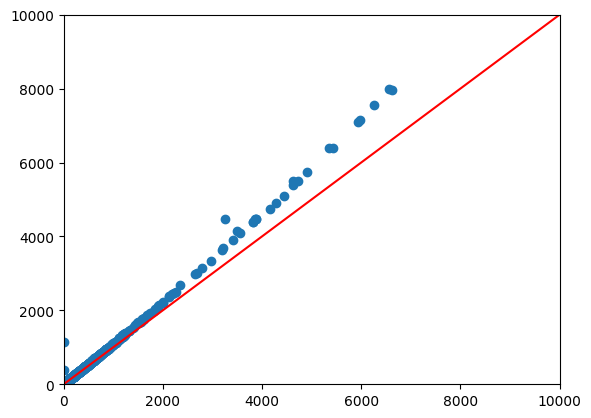

In [94]:
pl.scatter(x,y)
pl.plot(np.arange(40000),np.arange(40000),color='red')
pl.ylim([0,10000])
pl.xlim([0,10000])

In [93]:
13/len(x)

2.5126745100767913e-06

In [70]:
for i in sumLanes.columns:
    sub = sumLanes[i][sumLanes[i] > 10000]
    if len(sub) > 0:
        print(i)

Hashtag_1
Hashtag_2
Hashtag_3
Hashtag_4
Hashtag_5


In [92]:
7+2+2+1+1

13

In [91]:
len(sumLanes[sumLanes['Hashtag_1'] > 10000])

1

In [2]:
import matplotlib.pyplot as pl

# Huh clearly asymptotic in our benchmarking (not good)
- Probably ways that I can try to optimize that, but not worth it at the moment
- 

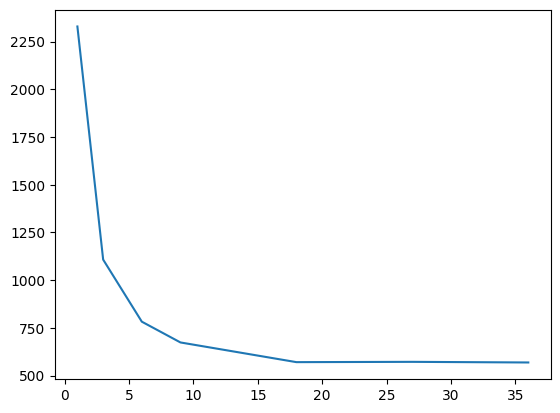

In [3]:
cores = [1,3,6,9,18,27,36]
times = [2328.68, 1107.76, 782.632, 673.81, 570.68, 572.23, 568.93]

pl.plot(cores,times)